# Amelia's Single-cell experiment - initial QC

## Load in libraries

In [1]:
import scanpy as sc

sc.logging.print_header()


scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


## Read in the folders

We will also add some metadata while reading in the folders.

In [2]:
folders = [
    "sample1_GEX_crepos_sLPL1",
    "sample2_GEX_crepos_sLPL2",
    "sample3_GEX_GF_sIEL",
    "sample4_GEX_GF_sLPL",
    "sample5_GEX_creneg_sIEL",
    "sample6_GEX_creneg_sLPL",
    "sample7_GEX_crepos_sIEL",
    "sample8_GEX_crepos_sLPL",
    "sample9_GEX_creneg_sIEL",
    "sample10_GEX_creneg_sLPL",
]

adatas = []
for sample in folders:
    try:
        tmp = sc.read_10x_h5(
            "/Volumes/SCRNAM2-Q6049/runs/"
            + sample
            + "/outs/filtered_feature_bc_matrix.h5"
        )
        tmp.var_names_make_unique()
        tmp.obs_names = [sample + "_" + x for x in tmp.obs_names]
        tmp.obs["sample_id"] = sample
        tmp.obs["sample_num"] = sample.split("_")[0]
        tmp.obs["group"] = sample.split("_")[2]
        tmp.obs["tissue"] = sample.split("_")[3][:4]
        adatas.append(tmp)
    except FileNotFoundError:
        print(f"The sample {sample} has no cells. Skipping")
        pass

/Users/uqztuong/miniconda3/envs/dandelion/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/uqztuong/miniconda3/envs/dandelion/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/uqztuong/miniconda3/envs/dandelion/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/uqztuong/miniconda3/envs/dandelion/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/uqztuong/miniconda3/envs/dandelion/lib/python3.10/sit

## Concatenate the files to make a single-object

In [3]:
adata = sc.concat(adatas)
adata


AnnData object with n_obs × n_vars = 11600 × 32285
    obs: 'sample_id', 'sample_num', 'group', 'tissue'

In [4]:
# save this object
import os

os.makedirs("write", exist_ok=True)

adata.layers["count"] = adata.X.copy()
adata.write_h5ad("write/adata_raw.h5ad", compression="gzip")
adata

AnnData object with n_obs × n_vars = 11600 × 32285
    obs: 'sample_id', 'sample_num', 'group', 'tissue'
    layers: 'count'

This tells us that there are 11600 possible cells (pre-QC) with 32285 genes

### Some preliminary QC plots

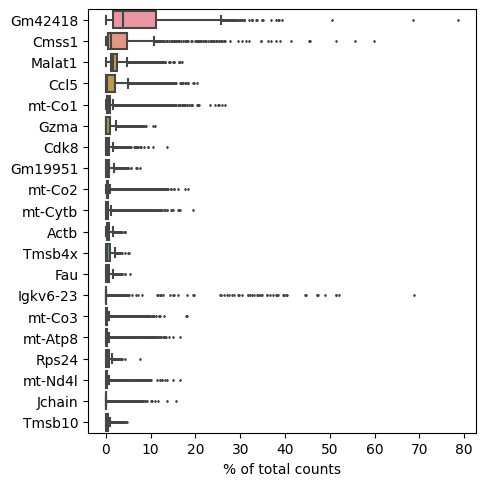

In [5]:
sc.pl.highest_expr_genes(
    adata,
    n_top=20,
)

## QC and Filtering

In [6]:
adata_raw = adata.copy()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 11193 × 18062
    obs: 'sample_id', 'sample_num', 'group', 'tissue', 'n_genes'
    var: 'n_cells'
    layers: 'count'

not bad, only removed about 400 cells.

## Populate QC metrics

In [7]:
adata.var["mt"] = adata.var_names.str.startswith(
    "mt-"
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

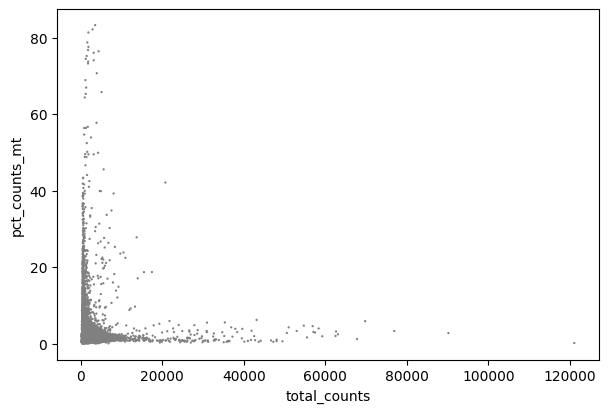

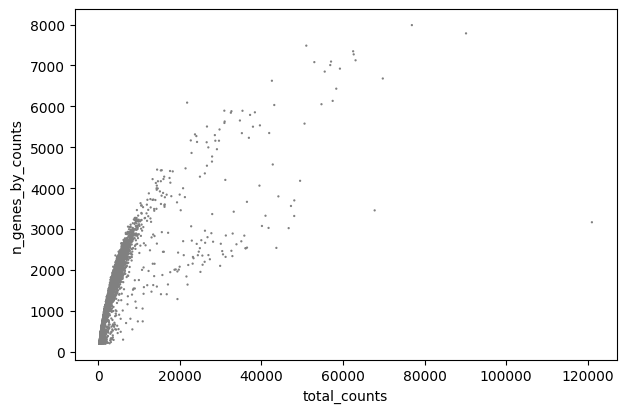

In [8]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [9]:
# also add ig as the contaminating genes
adata.var["ig"] = adata.var_names.str.startswith(
    ("Ig[hkl]", "Jchain")
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["ig"], percent_top=None, log1p=False, inplace=True
)

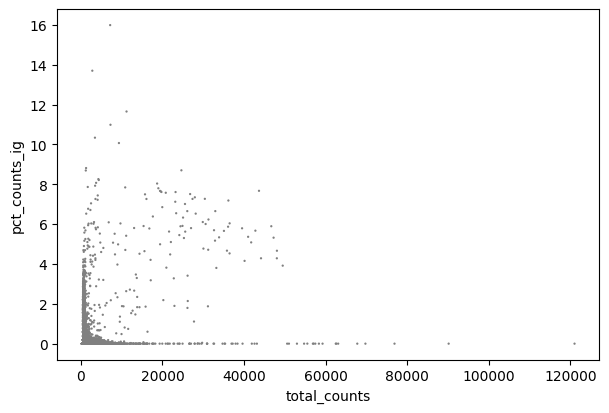

In [10]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_ig")
# sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

## More filtering

Keep only cells if they have less than 6000 genes, and only contain < 10% mitochondrial genes (high % indicates poor quality cell)

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata


View of AnnData object with n_obs × n_vars = 10568 × 18062
    obs: 'sample_id', 'sample_num', 'group', 'tissue', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ig', 'pct_counts_ig'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ig'
    layers: 'count'

## Normalise

Normalise to 10k counts per cell

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)

/Users/uqztuong/miniconda3/envs/dandelion/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Log transformation

In [13]:
sc.pp.log1p(adata)

## Find highly variable genes

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

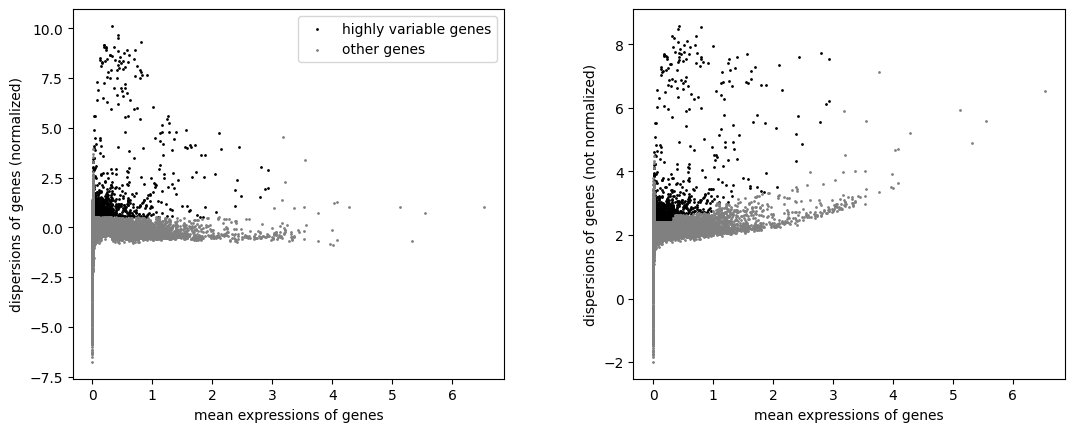

In [15]:
sc.pl.highly_variable_genes(adata)

## Remove VDJ genes from the highly variable genes

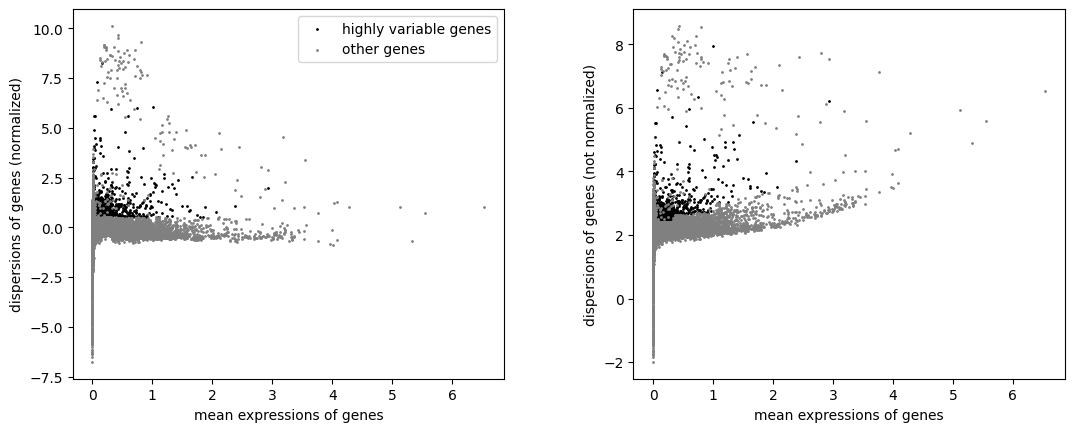

In [16]:
import re

for i in adata.var.index:
    if re.search("Tr[abdg][vdjc]|Tcr|Ig[hkl][vdjc]", i):
        adata.var.at[i, "highly_variable"] = False
sc.pl.highly_variable_genes(adata)

## stash a copy of the current data, and then filter to only highly variable genes

In [17]:
adata.raw = adata


In [18]:
adata = adata[:, adata.var.highly_variable].copy()
adata


AnnData object with n_obs × n_vars = 10568 × 1731
    obs: 'sample_id', 'sample_num', 'group', 'tissue', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ig', 'pct_counts_ig'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ig', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'count'

## regress out covariates prior to PCA

In [19]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

## scale counts

In [20]:
sc.pp.scale(adata, max_value=10)

## PCA

In [21]:
sc.tl.pca(adata, svd_solver="arpack")

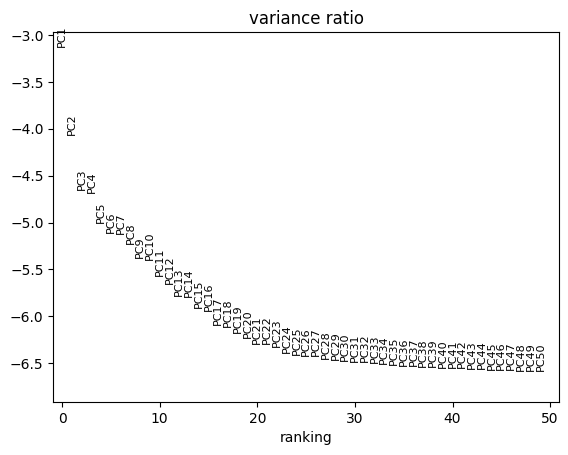

In [22]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)


## compute neighborhood graph

In [23]:
sc.pp.neighbors(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## UMAP

In [24]:
sc.tl.umap(adata, min_dist=0.3)

## Clustering

In [25]:
sc.tl.leiden(adata)


## Visualise the results

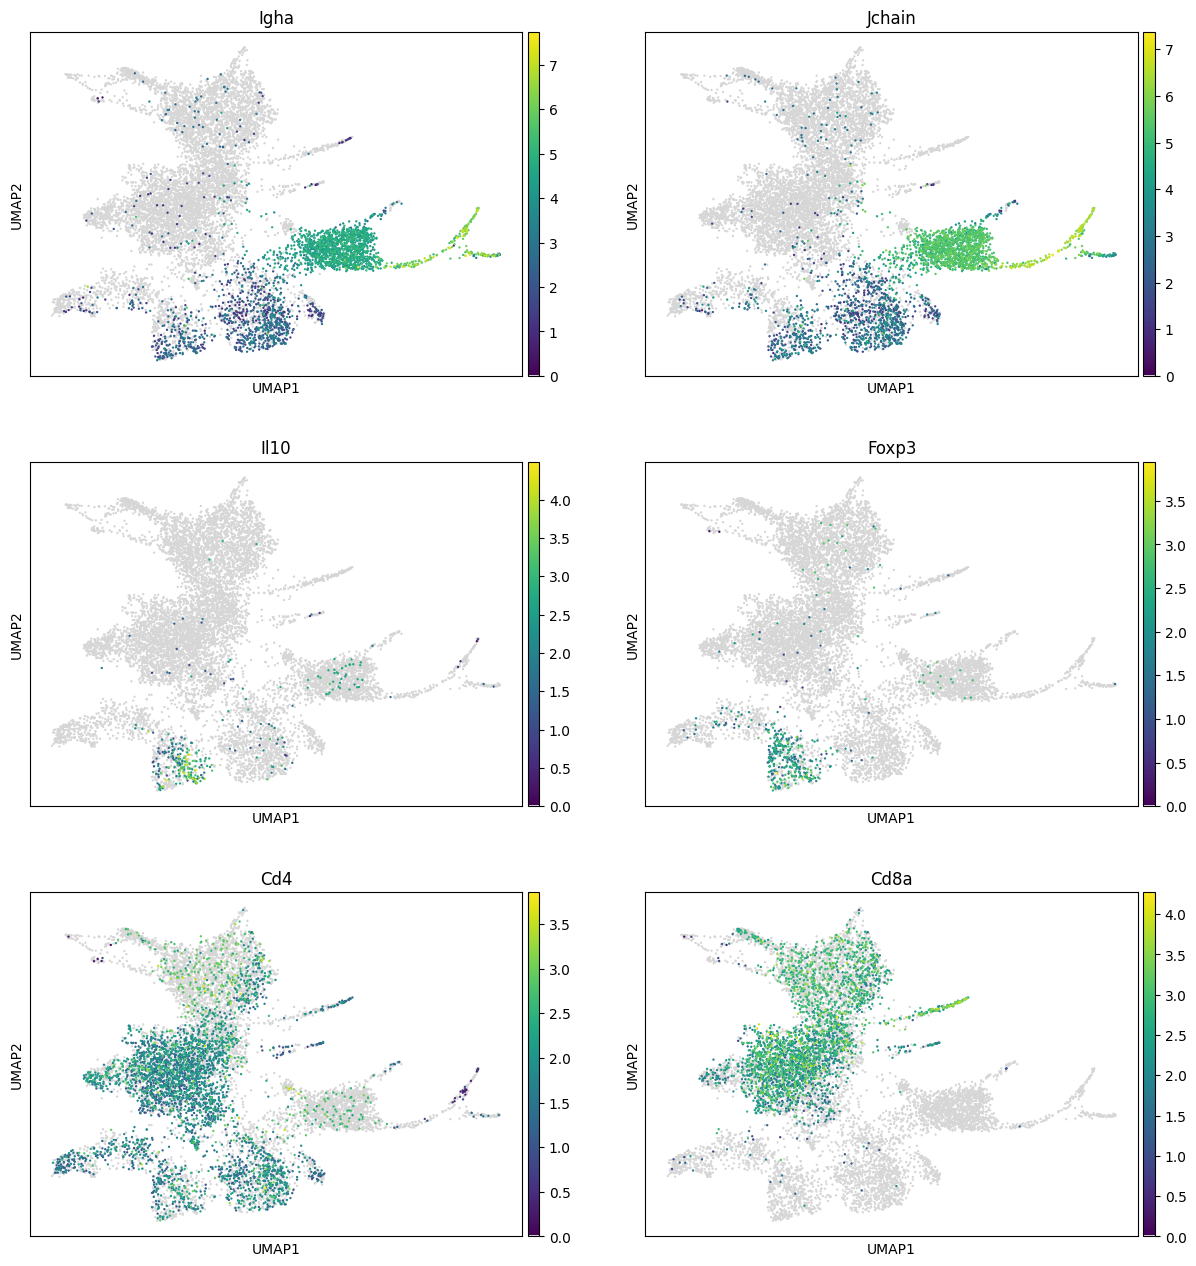

In [26]:
import tools

sc.pl.umap(
    adata,
    color=[
        "Igha",
        "Jchain",
        "Il10",
        "Foxp3",
        "Cd4",
        "Cd8a",
    ],
    color_map=tools.cmp(),
    ncols=2,
)

/Users/uqztuong/miniconda3/envs/dandelion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/uqztuong/miniconda3/envs/dandelion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/uqztuong/miniconda3/envs/dandelion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/uqztuong/miniconda3/envs/dandelion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


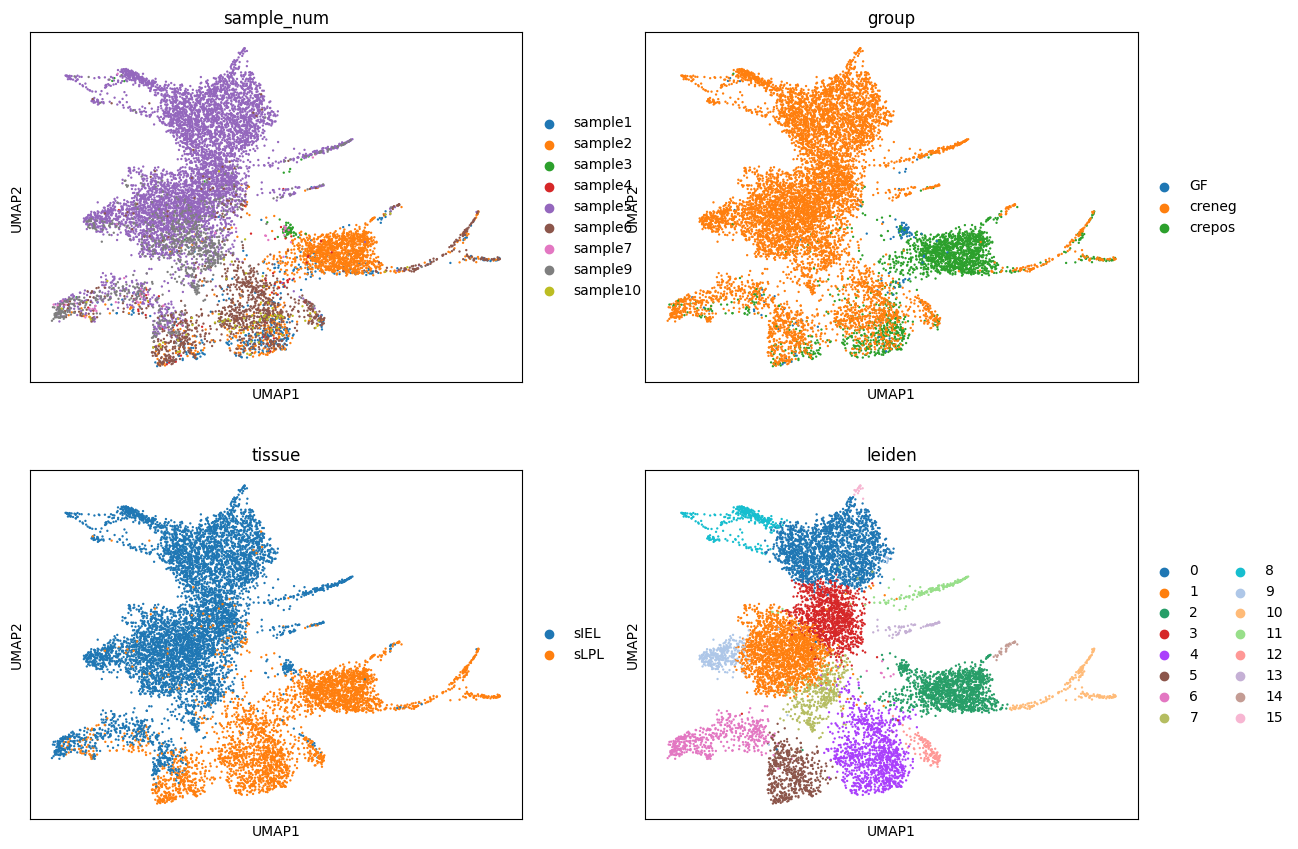

In [27]:
sc.pl.umap(
    adata,
    color=[
        "sample_num",
        "group",
        "tissue",
        "leiden",
    ],
    ncols=2,
)


# Prepare TCR

In [28]:
import dandelion as ddl


In [29]:
folders = [
    "sample11_TCR_crepos_sLPL1",
    "sample12_TCR_crepos_sLPL2",
    "sample13_TCR_GF_sIEL",
    "sample14_TCR_GF_sLPL",
    "sample15_TCR_creneg_sIEL",
    "sample16_TCR_creneg_sLPL",
    "sample17_TCR_crepos_sIEL",
    "sample18_TCR_crepos_sLPL",
    "sample19_TCR_creneg_sIEL",
    "sample20_TCR_creneg_sLPL",
]
folders_dict = {
    "sample11_TCR_crepos_sLPL1": "sample1_GEX_crepos_sLPL1",
    "sample12_TCR_crepos_sLPL2": "sample2_GEX_crepos_sLPL2",
    "sample13_TCR_GF_sIEL": "sample3_GEX_GF_sIEL",
    "sample14_TCR_GF_sLPL": "sample4_GEX_GF_sLPL",
    "sample15_TCR_creneg_sIEL": "sample5_GEX_creneg_sIEL",
    "sample16_TCR_creneg_sLPL": "sample6_GEX_creneg_sLPL",
    "sample17_TCR_crepos_sIEL": "sample7_GEX_crepos_sIEL",
    "sample18_TCR_crepos_sLPL": "sample8_GEX_crepos_sLPL",
    "sample19_TCR_creneg_sIEL": "sample9_GEX_creneg_sIEL",
    "sample20_TCR_creneg_sLPL": "sample10_GEX_creneg_sLPL",
}

vdjs = []
for sample in folders:
    try:
        tmp = ddl.read_10x_vdj(
            "/Volumes/SCRNAM2-Q6049/runs/" + sample + "/outs",
        )
        tmp.data.cell_id = [folders_dict[sample] + "_" + x for x in tmp.data.cell_id]
        tmp.data.sequence_id = [
            folders_dict[sample] + "_" + x for x in tmp.data.sequence_id
        ]
        vdjs.append(tmp)
    except OSError:
        print(f"The sample {sample} has no cells. Skipping")
        pass
vdj = ddl.concat(vdjs)
vdj


The sample sample18_TCR_crepos_sLPL has no cells. Skipping


Dandelion class object with n_obs = 9463 and n_contigs = 16212
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'complete_vdj', 'vj_in_frame', 'junction', 'junction_aa', 'locus', 'v_call', 'j_call', 'c_call', 'd_call', 'consensus_count', 'duplicate_count', 'cdr3_start', 'cdr3_end', 'fwr1_start', 'fwr1_end', 'fwr1', 'fwr1_aa', 'cdr1_start', 'cdr1_end', 'cdr1', 'cdr1_aa', 'fwr2_start', 'fwr2_end', 'fwr2', 'fwr2_aa', 'cdr2_start', 'cdr2_end', 'cdr2', 'cdr2_aa', 'fwr3_start', 'fwr3_end', 'fwr3', 'fwr3_aa', 'fwr4_start', 'fwr4_end', 'fwr4', 'fwr4_aa', 'clone_id', 'raw_consensus_id_10x', 'exact_subclonotype_id_10x', 'high_confidence_10x', 'filtered_10x', 'is_cell_10x', 'is_asm_cell_10x', 'rearrangement_status'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'juncti

In [30]:
vdjx, adatax = ddl.pp.filter_contigs(vdj, adata)

Preparing data: 11511it [00:01, 10890.40it/s]
Scanning for poor quality/ambiguous contigs: 100%|██████████| 7762/7762 [00:08<00:00, 968.17it/s] 


In [31]:
vdjx


Dandelion class object with n_obs = 4605 and n_contigs = 7776
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'complete_vdj', 'vj_in_frame', 'junction', 'junction_aa', 'locus', 'v_call', 'j_call', 'c_call', 'd_call', 'consensus_count', 'duplicate_count', 'cdr3_start', 'cdr3_end', 'fwr1_start', 'fwr1_end', 'fwr1', 'fwr1_aa', 'cdr1_start', 'cdr1_end', 'cdr1', 'cdr1_aa', 'fwr2_start', 'fwr2_end', 'fwr2', 'fwr2_aa', 'cdr2_start', 'cdr2_end', 'cdr2', 'cdr2_aa', 'fwr3_start', 'fwr3_end', 'fwr3', 'fwr3_aa', 'fwr4_start', 'fwr4_end', 'fwr4', 'fwr4_aa', 'clone_id', 'raw_consensus_id_10x', 'exact_subclonotype_id_10x', 'high_confidence_10x', 'filtered_10x', 'is_cell_10x', 'is_asm_cell_10x', 'rearrangement_status'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junctio

In [32]:
adatax


AnnData object with n_obs × n_vars = 10568 × 1731
    obs: 'sample_id', 'sample_num', 'group', 'tissue', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ig', 'pct_counts_ig', 'leiden', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig', 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'duplicate_count_abT_VDJ', 'duplicate_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_abT_VDJ_main', 'd_call_a

/Users/uqztuong/miniconda3/envs/dandelion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


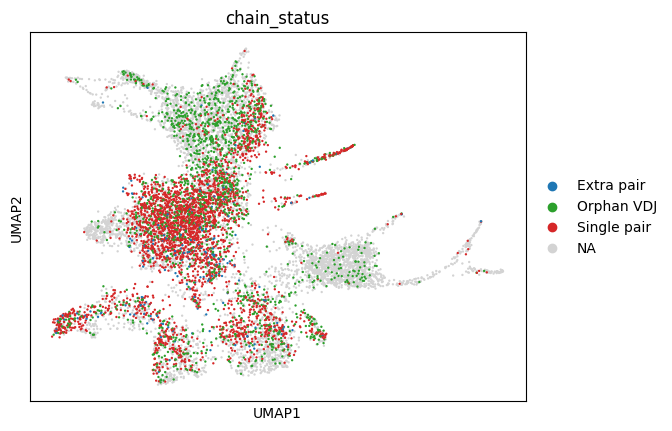

In [33]:
sc.pl.umap(
    adatax,
    color=[
        "chain_status",
    ],
    groups=["Extra pair", "Orphan VDJ", "Single pair"],
)

In [34]:
adatax

AnnData object with n_obs × n_vars = 10568 × 1731
    obs: 'sample_id', 'sample_num', 'group', 'tissue', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ig', 'pct_counts_ig', 'leiden', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig', 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'duplicate_count_abT_VDJ', 'duplicate_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_abT_VDJ_main', 'd_call_a

### Save the results

In [35]:
adatax.write_h5ad("write/adata_with_tcr.h5ad", compression="gzip")

In [36]:
vdjx.write_h5ddl("write/tcr_data.h5ddl")

In [37]:
adata.write_h5ad("write/adata_no_tcr.h5ad", compression="gzip")